In [2]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from math import sqrt
from matplotlib import pyplot as plt
import seaborn as sns
# allow plots to appear directly in the notebook
%matplotlib inline

Create the connection and load the data into a pd dataframe.

In [3]:
cnx = sqlite3.connect('players-database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [4]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


# check for null values 

In [5]:
df.isnull().any()

id                     False
player_fifa_api_id     False
player_api_id          False
date                   False
overall_rating          True
potential               True
preferred_foot          True
attacking_work_rate     True
defensive_work_rate     True
crossing                True
finishing               True
heading_accuracy        True
short_passing           True
volleys                 True
dribbling               True
curve                   True
free_kick_accuracy      True
long_passing            True
ball_control            True
acceleration            True
sprint_speed            True
agility                 True
reactions               True
balance                 True
shot_power              True
jumping                 True
stamina                 True
strength                True
long_shots              True
aggression              True
interceptions           True
positioning             True
vision                  True
penalties               True
marking       

In [6]:
df1 = df[df.overall_rating.isnull()]
df1

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
483,484,33022,31684,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983,984,111085,29904,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1752,1753,165740,24159,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2089,2090,176941,31916,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2482,2483,177615,37249,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2498,2499,177713,40012,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2540,2541,2115,38612,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3283,3284,152769,41109,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4006,4007,172176,23163,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4202,4203,140307,32547,2007-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


836 records which have "overall_rating" as null have null values in all the columns. We can safely drop them.

In [7]:
df = df[~df.overall_rating.isnull()]

In [8]:
#check again for null values 

df.isnull().any()

id                     False
player_fifa_api_id     False
player_api_id          False
date                   False
overall_rating         False
potential              False
preferred_foot         False
attacking_work_rate     True
defensive_work_rate    False
crossing               False
finishing              False
heading_accuracy       False
short_passing          False
volleys                 True
dribbling              False
curve                   True
free_kick_accuracy     False
long_passing           False
ball_control           False
acceleration           False
sprint_speed           False
agility                 True
reactions              False
balance                 True
shot_power             False
jumping                 True
stamina                False
strength               False
long_shots             False
aggression             False
interceptions          False
positioning            False
vision                  True
penalties              False
marking       

In [9]:
# replace NANs with series mean

df["volleys"].fillna(df["volleys"].mean(),inplace=True)
df["curve"].fillna(df["curve"].mean(),inplace=True)
df["agility"].fillna(df["agility"].mean(),inplace=True)
df["balance"].fillna(df["balance"].mean(),inplace=True)
df["jumping"].fillna(df["jumping"].mean(),inplace=True)
df["vision"].fillna(df["vision"].mean(),inplace=True)
df["sliding_tackle"].fillna(df["sliding_tackle"].mean(),inplace=True)

# Convert categorical values to numerics

# preferred_foot

In [10]:
df.preferred_foot.value_counts()

right    138409
left      44733
Name: preferred_foot, dtype: int64

In [11]:
df['preferred_foot'] = df['preferred_foot'].map( {'right': 0, 'left': 1} ).astype(int)

# defensive_work_rate

In [12]:
df.defensive_work_rate.value_counts()

medium    130846
high       27041
low        18432
_0          2394
o           1550
1            441
ormal        348
2            342
3            258
5            234
7            217
6            197
0            197
9            152
4            116
es           106
ean          104
tocky         89
8             78
Name: defensive_work_rate, dtype: int64

Converting defensive_work_rate is tricky. The acceptable values are high, medium and low, but the column has lot of other values which don't make sense. And since we don't have the metadata available for the column, the safest choice would be to drop all the rows having non-sensical values. But before we do that, lets try to make sense of the given data.

Few rows have numerical values ranging from 0-9. For them, we can assume that 0-3 means "low", 4-6 means "medium", 7-9 means high. Three other values "o", "_0" and "ormal" can be interpreted as "0", "0" and "normal" which can in turn be interpreted as "low", "low" and "medium". Rest of the rows can be dropped.

In [13]:
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('_0','0')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('ormal','5')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('o','0')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('l0w','low')

In [14]:
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('0','low')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('1','low')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('2','low')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('3','low')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('4','medium')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('5','medium')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('6','medium')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('7','high')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('8','high')
df['defensive_work_rate'] = df['defensive_work_rate'].str.replace('9','high')

Choose only the rows having work rate as low, medium and high

In [15]:
df = df[(df.defensive_work_rate == 'medium') | (df.defensive_work_rate == 'high') | (df.defensive_work_rate == 'low')]

In [16]:
df.defensive_work_rate.value_counts()

medium    131741
high       27488
low        23614
Name: defensive_work_rate, dtype: int64

# attacking_work_rate

In [17]:
df.attacking_work_rate.value_counts()

medium    125070
high       42823
low         8569
None        3639
norm         348
Name: attacking_work_rate, dtype: int64

Converting attacking_work_rate is again tricky. The acceptable values are high, medium and low, but the column has other values which don't make much sense. And since we don't have the metadata available for this column, the safest choice would be to drop all the rows having values other than low, high and medium.

In [18]:
# Change "norm" to "medium" and drop the rest having "None" and "Null" values.

df['attacking_work_rate'] = df['attacking_work_rate'].str.replace('norm','medium')
df = df[(df.attacking_work_rate == 'medium') | (df.attacking_work_rate == 'high') | (df.attacking_work_rate == 'low')]

# dummify the catergorical columns 

In [19]:
df_dummified = pd.get_dummies(df,columns=['attacking_work_rate','defensive_work_rate'])

In [20]:
df_dummified.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'marking',
       'standing_tackle', 'sliding_tackle', 'gk_diving', 'gk_handling',
       'gk_kicking', 'gk_positioning', 'gk_reflexes',
       'attacking_work_rate_high', 'attacking_work_rate_low',
       'attacking_work_rate_medium', 'defensive_work_rate_high',
       'defensive_work_rate_low', 'defensive_work_rate_medium'],
      dtype='object')

The columns that we will be making predictions with.

In [21]:
X = df_dummified[['potential', 'preferred_foot', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'marking',
       'standing_tackle', 'sliding_tackle',
       'attacking_work_rate_high', 'attacking_work_rate_low',
       'attacking_work_rate_medium', 'defensive_work_rate_high',
       'defensive_work_rate_low', 'defensive_work_rate_medium']]

The column that we want to predict.

In [22]:
y = df_dummified["overall_rating"]

# linear regression

instantiate a linear regression model and fit with X and y. 

In [23]:
model = LinearRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.7918552997568186

79% accuracy

Evaluate the model by splitting into train and test sets.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)
model2 = LinearRegression()
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)
predicted
print(metrics.r2_score(y_test, predicted))

0.7901853403251381


The accuracy is 79%, which is the same as we experienced when training and predicting on the same data.

In [25]:
# examine the coefficients

pd.DataFrame({"features": X.columns, "co-efficients": model.coef_})

,features,co-efficients
0,potential,0.505647
1,preferred_foot,-0.003008
2,crossing,0.039041
3,finishing,0.001025
4,heading_accuracy,-0.018488
5,short_passing,0.002027
6,volleys,-0.001316
7,dribbling,-0.018032
8,curve,0.004088
9,free_kick_accuracy,0.005605


PLOT true vs predicted scores and draw the line of fit

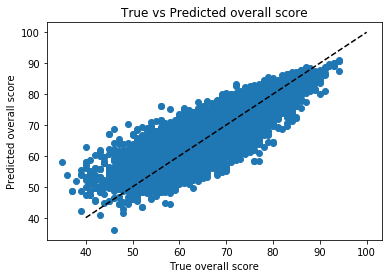

In [26]:
plt.scatter(y_test, predicted)
plt.plot([40, 100], [40, 100], '--k')
plt.xlabel("True overall score")
plt.ylabel("Predicted overall score")
plt.title("True vs Predicted overall score")
plt.show()

Draw residual plot. If the data points are scattered randomly around the line, then our model is correct 
and it's not missing the relationship between any two features.

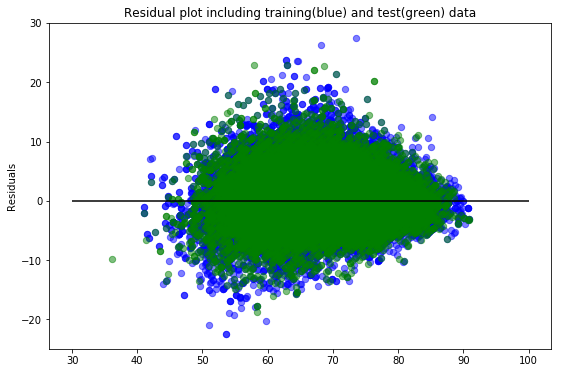

In [27]:
plt.figure(figsize=(9,6))
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c='g', s=40, alpha=0.5)
plt.hlines(y=0, xmin=30, xmax=100)
plt.ylabel('Residuals')
plt.title('Residual plot including training(blue) and test(green) data')
plt.show()

Evaluate the model using 10-fold cross-validation

In [28]:
scores = cross_val_score(LinearRegression(), X, y, cv=10)
scores, scores.mean()

(array([0.80034605, 0.79766127, 0.7862824 , 0.78127698, 0.78735567,
        0.77608546, 0.81278083, 0.78594717, 0.78632066, 0.79546977]),
 0.7909526278716857)

In [29]:
predictions = cross_val_predict(LinearRegression(), X, y, cv=7)
print(metrics.r2_score(y_test, predicted))

0.7901853403251381


Accuracy still at 79%

# Decision Tree 

Instantiate a decision tree regression model and and fit with X and y

In [29]:
model = DecisionTreeRegressor()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.9990822907769314

99.9% accuracy. Over-fitting suspect.

Evaluate the model by splitting into train and test sets.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model2 = DecisionTreeRegressor(random_state=0)
model2.fit(X_train, y_train)
predicted = model2.predict(X_test)
print ("Accuracy score is", round(metrics.r2_score(y_test, predicted) * 100, 2), '%')

Accuracy score is 94.97 %


Evaluate the model using 10-fold cross-validation

In [31]:
scores = cross_val_score(DecisionTreeRegressor(), X, y, cv=10)
scores, scores.mean()

(array([0.85380005, 0.84298866, 0.84092851, 0.84461638, 0.84417712,
        0.84225588, 0.85216159, 0.84265597, 0.84482252, 0.84466519]),
 0.8453071881458019)

In [32]:
predictions = cross_val_predict(DecisionTreeRegressor(), X, y, cv=7)
r2_score = metrics.r2_score(y_test, predicted)
print("Accuracy after Cross validation: {}".format(r2_score * 100))

Accuracy after Cross validation: 94.97302584192556


Accuracy still at above 94%. Perform GridSerach on the parameter max_depth and min_samples_split, then use the best estimator for scoring on the valiation set.

In [33]:
parameters = [{'max_depth': range(25, 30), 'min_samples_split': range(2, 10)}]

reg = GridSearchCV(DecisionTreeRegressor(random_state=0), parameters, scoring='neg_mean_squared_error')
reg.fit(X_train, y_train)

print("Best parameters set found on development set:\n")
print(reg.best_params_)

print("Accuracy for test data set:\n")
predicted = reg.predict(X_test)
print(metrics.r2_score(y_test, predicted))

Best parameters set found on development set:

{'max_depth': 27, 'min_samples_split': 3}
Accuracy for test data set:

0.9490400650782921


The accuracy is now close to 95%. We have done train-test splits, cross validation and grid search to find the optimal paramters to reduce overfitting. It's probably safe to say that Decision tree regression is better at predictions in this particular case than linear regression, though over-fitting still can't be completely ruled out.